# Background:
In our ongoing EEG data analysis project, we've been examining correlation metrics between various sessions and blocks to understand underlying patterns and their potential implications for EEG image decoding. The focus of this phase is on subject 1 session 1, comparing correlations of EEG data across similar and different conditions.

# Objective:
Evaluate the consistency and variability of correlation coefficients between trials in the EEG2 dataset, especially focusing on their potential to support successful image reconstruction.

These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources (can be run in this colab)


## Task 1: Dataset preparation

Our dataset is already on the server.

## Task 2: Visualize EEG
Below is a boilerplate code to visualize data downloaded from OSF. Please adapt it to work with your downloaded data. The task is to fix a bug that prevents the code from running.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [8]:
img_directory_training = "/srv/eeg_reconstruction/shared/things_eeg_2/y63gw/osfstorage/training_images"
EEG_PATH = "/srv/eeg_reconstruction/shared/things_eeg_2/Preprocessed_data_250Hz/sub-01/preprocessed_eeg_training.npy"

# Load image and texts
directory = img_directory_training
img_directory = img_directory_training
dirnames = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
dirnames.sort()

data_list = []
label_list = []
texts = []
images = []

for dir in dirnames:
    try:
        idx = dir.index('_')
        description = dir[idx+1:]
    except ValueError:
        print(f"Skipped: {dir} due to no '_' found.")
        continue

    new_description = f"This picture is {description}"
    texts.append(new_description)

all_folders = [d for d in os.listdir(img_directory) if os.path.isdir(os.path.join(img_directory, d))]
all_folders.sort()

for folder in all_folders:
    folder_path = os.path.join(img_directory, folder)
    all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    all_images.sort()
    images.extend(os.path.join(folder_path, img) for img in all_images)

# load EEGs
data = np.load(EEG_PATH, allow_pickle=True)
preprocessed_eeg_data = data['preprocessed_eeg_data']

n_classes = 1654
samples_per_class = 10

for i in range(n_classes):
    start_index = i * samples_per_class
    preprocessed_eeg_data_class = preprocessed_eeg_data[start_index: start_index+samples_per_class]
    labels = i
    data_list.append(preprocessed_eeg_data_class)
    label_list.append(labels)

In [18]:
def find_matching_in_block(dataset):
    seen_ids = {}

    for row in dataset:
        id = row["73k_id"]

        if id in seen_ids:
            return seen_ids[id], row

        seen_ids[id] = row

    return None, None # return none if none are matching

def find_nonmatching_in_block(dataset):
    block_data_list = list(dataset)

    found = False
    while not found:
        # Randomly select two different rows
        row1, row2 = random.sample(block_data_list, 2)
        found = row1['73k_id'] != row2['73k_id']

    return row1, row2

def corrcoef(eeg1, eeg2):
    return np.array([np.corrcoef(eeg1[i], eeg2[i])[0, 1] for i in range(63)])
# def corrcoef(eeg1, eeg2):
#     return np.array([np.corrcoef(eeg1[i], eeg2[i])[0, 1] for i in range(17)])

In [19]:
data_list[15].shape
# This is the 15th image class, which has 10 images, 4 repetitions, 17 channels, and 100 time points

(10, 4, 63, 250)

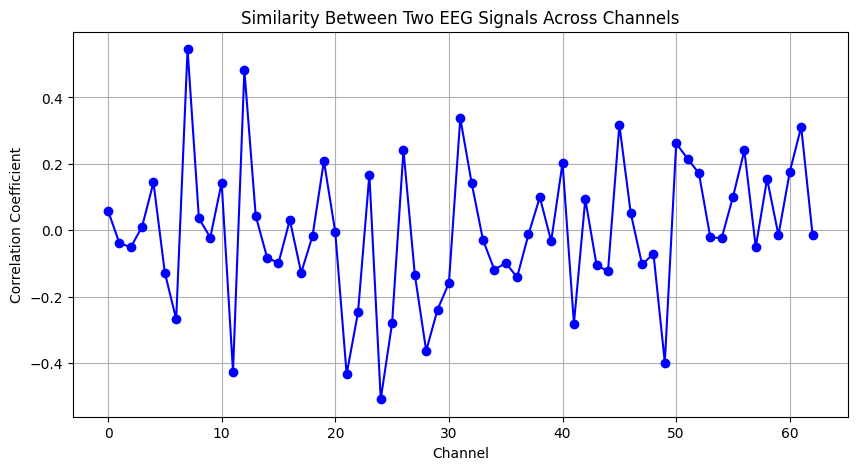

Average similarity across all channels: -0.00


In [20]:
# Get similarities
same1, same2 = data_list[15][0][0], data_list[15][0][1]

similarities = corrcoef(same1, same2)
# Average similarity
average_similarity = np.mean(similarities)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(similarities, marker='o', linestyle='-', color='b')
plt.title('Similarity Between Two EEG Signals Across Channels')
plt.xlabel('Channel')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

print(f"Average similarity across all channels: {average_similarity:.2f}")

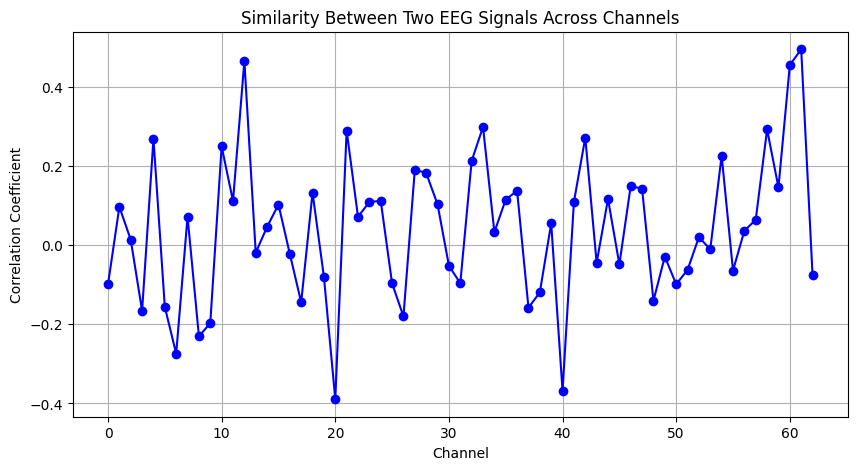

Average similarity across all channels: 0.04


In [21]:
# Get similarities
diff1, diff2 = data_list[500][0][1], data_list[15][0][1]
similarities = corrcoef(diff1, diff2)
# Average similarity
average_similarity = np.mean(similarities)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(similarities, marker='o', linestyle='-', color='b')
plt.title('Similarity Between Two EEG Signals Across Channels')
plt.xlabel('Channel')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

print(f"Average similarity across all channels: {average_similarity:.2f}")

## Task 3: Correlation Distributions

This is a naive visualization that shows the correlation distribution for EEG responses to the same image vs different images. You can see that this naive correlation does not differentiate between same and different image responses.

In [22]:
def generate_pairs(eeg):
    same_id_pairs = []
    different_id_pairs = []
    totalCount = 100

    for i in range(totalCount):
        category1 = random.randint(0, len(eeg)-1)
        category2 = random.randint(0, len(eeg)-1)
        if category1 == category2:
            category2 += 1

        # First image from the category, first and second response
        same_pair = (eeg[category1][0][0], eeg[category1][0][1])
        same_id_pairs.append(same_pair)

        # First image from category1 and first image from category2
        diff_pair = (eeg[category1][0][0], eeg[category2][0][0])
        different_id_pairs.append(diff_pair)

    return same_id_pairs, different_id_pairs

def calculate_correlations(pairs):
    correlations = []
    for row1, row2 in pairs:
        correlation = corrcoef(row1, row2)
        correlations.append(correlation)
    return correlations

In [23]:
matching_correlations = []
nonmatching_correlations = []

# Assuming 'dataset' is a list of dictionaries and 'block' is a valid key
same_id_pairs, different_id_pairs = generate_pairs(data_list)

matching_correlations.extend(calculate_correlations(same_id_pairs))
nonmatching_correlations.extend(calculate_correlations(different_id_pairs))

T-statistic: 1.619820331056496, P-value: 0.10690994006904606


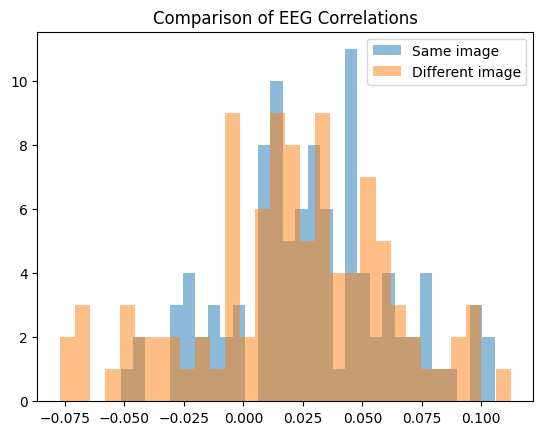

In [24]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Example of T-test
t_stat, p_value = ttest_ind([np.mean(corr) for corr in matching_correlations],
                            [np.mean(corr) for corr in nonmatching_correlations], equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Plotting histograms
plt.hist([np.mean(corr) for corr in matching_correlations], bins=30, alpha=0.5, label='Same image')
plt.hist([np.mean(corr) for corr in nonmatching_correlations], bins=30, alpha=0.5, label='Different image')
plt.legend()
plt.title('Comparison of EEG Correlations')
plt.show()

T-statistic: 1.3770560646251364, P-value: 0.17005294642157284


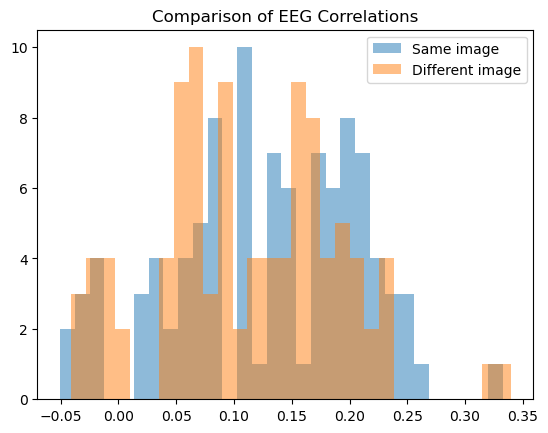

In [12]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Example of T-test
t_stat, p_value = ttest_ind([np.mean(corr) for corr in matching_correlations],
                            [np.mean(corr) for corr in nonmatching_correlations], equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Plotting histograms
plt.hist([np.mean(corr) for corr in matching_correlations], bins=30, alpha=0.5, label='Same image')
plt.hist([np.mean(corr) for corr in nonmatching_correlations], bins=30, alpha=0.5, label='Different image')
plt.legend()
plt.title('Comparison of EEG Correlations')
plt.show()

## Task 4: Advanced Correlation Analysis Using Representational Similarity Analysis (RSA)

Now that you are familiar with loading and visualizing our dataset, your task is to visualize correlations of the EEG data in a more helpful metric.

**Objective**:
Refine EEG data analysis by implementing Representational Similarity Analysis (RSA) to better differentiate EEG responses to same versus different images, focusing on category-level distinctions.

**Background**:
While previous analyses have highlighted general correlations, a more detailed RSA could reveal stronger distinctions in the EEG responses when subjects view the same versus different images. This refined analysis might better capture the nuances in EEG patterns related to visual processing, especially at the category level.

**Task Description**
1. Temporal Feature Extraction:
Implement a sliding window technique (200 ms window, 10 ms steps) to capture dynamic changes in the EEG signals. For each window, construct 17-channel by 81 time points EEG feature vectors.
2. RSA Implementation:
Compute Spearman correlations for all pairwise combinations of trials to generate an n trials x n trials correlation matrix.
Distinguish between within-category (same-image) and between-category (different-image) pairs for analysis.
3. Analysis:
Calculate the average correlation coefficients for same-image pairs versus different-image pairs.
Utilize statistical tests, such as the t-test, to compare these groups and determine if there are significant differences.
4. Visualization:
Plot histograms or boxplots to visually compare the distribution of correlation coefficients between the two groups.

The goal is to see a visible difference in the distribution of correlation coefficients between responses to the same and different image stimuli.

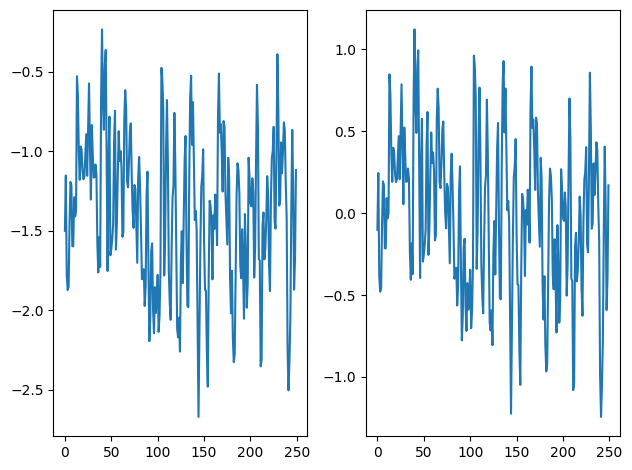

In [29]:
one_channel = eeg_data[0][0][0][0]
filtered = high_pass_filter(one_channel)

fig, axs = plt.subplots(1,2)
axs[0].plot(one_channel)
axs[1].plot(filtered)

plt.tight_layout()
plt.show()

In [32]:
testt = np.array(same_id_pairs)
print(testt.shape)

(100, 2, 63, 250)


In [25]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.signal import butter, filtfilt

# # Convert to numpy array
# eeg_data = np.array(data_list)
# labels = np.array(label_list)

# # Check the shape of the EEG data
# print("EEG data shape:", eeg_data.shape)

# # Function to apply high-pass filter
# def high_pass_filter(data, cutoff=0.5, fs=128):
#     b, a = butter(3, cutoff / (0.5 * fs), btype='high')
#     return filtfilt(b, a, data)

# # Apply high-pass filter to EEG data
# eeg_data_filtered = np.array([[[[high_pass_filter(trial) for trial in rep] for rep in img_trials] for img_trials in class_trials] for class_trials in eeg_data])

# # Check the shape of the filtered EEG data
# print("Filtered EEG data shape:", eeg_data_filtered.shape)


same_id_pairs, different_id_pairs
# Compute correlations
def calculate_pearsons(pairs):
    correlations = []
    for row1, row2 in pairs:
        correlation = pearsonr(row1.flatten(), row2.flatten())
        correlations.append(correlation)
    return correlations

# Function to create confusion matrix
def create_confusion_matrix(same_image_corrs, different_image_corrs, size=10):
    """
    Create a confusion matrix comparing Pearson correlations for the same and different images.
    """
    matrix = np.zeros((size, size))
    
    # Fill the diagonal with correlations of the same images (repeated trials)
    np.fill_diagonal(matrix, same_image_corrs[:size])
    
    # Fill the off-diagonal with correlations of different images
    for i in range(size):
        for j in range(i + 1, size):
            if different_image_corrs:
                matrix[i, j] = different_image_corrs.pop(0)
                matrix[j, i] = matrix[i, j]
    
    return matrix


same_id_pairs, different_id_pairs = generate_pairs(data_list)
matching_correlations = calculate_pearsons(same_id_pairs)
nonmatching_correlations = calculate_pearsons(different_id_pairs)

# Create the confusion matrix
confusion_matrix = create_confusion_matrix(same_image_corrs, different_image_corrs, size=10)

# Create labels for the axes
image_labels = [f"Image {i+1}" for i in range(100)]

# Display the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, cmap='viridis', interpolation='none')
plt.colorbar(label='Pearson Correlation')
plt.title('Confusion Matrix of Pearson Correlations (Subset)')
plt.xlabel('Trials/Images')
plt.ylabel('Trials/Images')
plt.xticks(ticks=np.arange(10), labels=image_labels, rotation=45)
plt.yticks(ticks=np.arange(10), labels=image_labels)
plt.show()


EEG data shape: (1654, 10, 4, 63, 250)


KeyboardInterrupt: 

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Function to load images and get directory names
def get_image_directories(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Function to compute correlation matrix
def compute_correlation_matrix(eeg_data, n_images=100):
    correlations = np.zeros((n_images, n_images))
    for i in range(n_images):
        for j in range(n_images):
            correlations[i, j] = pearsonr(eeg_data[i].flatten(), eeg_data[j].flatten())[0]
    return correlations

# Load EEG data and preprocess it
EEG_PATH = "/Users/samaylakhani/Documents/BCI_Full_Folder/ALllJoined/takehome/sub-01/preprocessed_eeg_training.npy"
data = np.load(EEG_PATH, allow_pickle=True)
preprocessed_eeg_data = data.item()['preprocessed_eeg_data']

# Assuming the EEG data is already filtered and windowed appropriately
# If not, apply the necessary preprocessing steps here

# Get directory names for labels
img_directory_training = "/Users/samaylakhani/Documents/BCI_Full_Folder/ALllJoined/takehome/training_images"
image_directories = get_image_directories(img_directory_training)

# Compute the correlation matrix for the first 100 images
n_images = 100
correlation_matrix = compute_correlation_matrix(preprocessed_eeg_data[:n_images])

# Plotting the correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, xticklabels=image_directories[:n_images], yticklabels=image_directories[:n_images], cmap='viridis')
plt.title('Confusion Matrix of Pearson Correlations (100x100)')
plt.xlabel('Trials/Images')
plt.ylabel('Trials/Images')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
# plt.colorbar(label='Pearson Correlation')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/image.png'

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

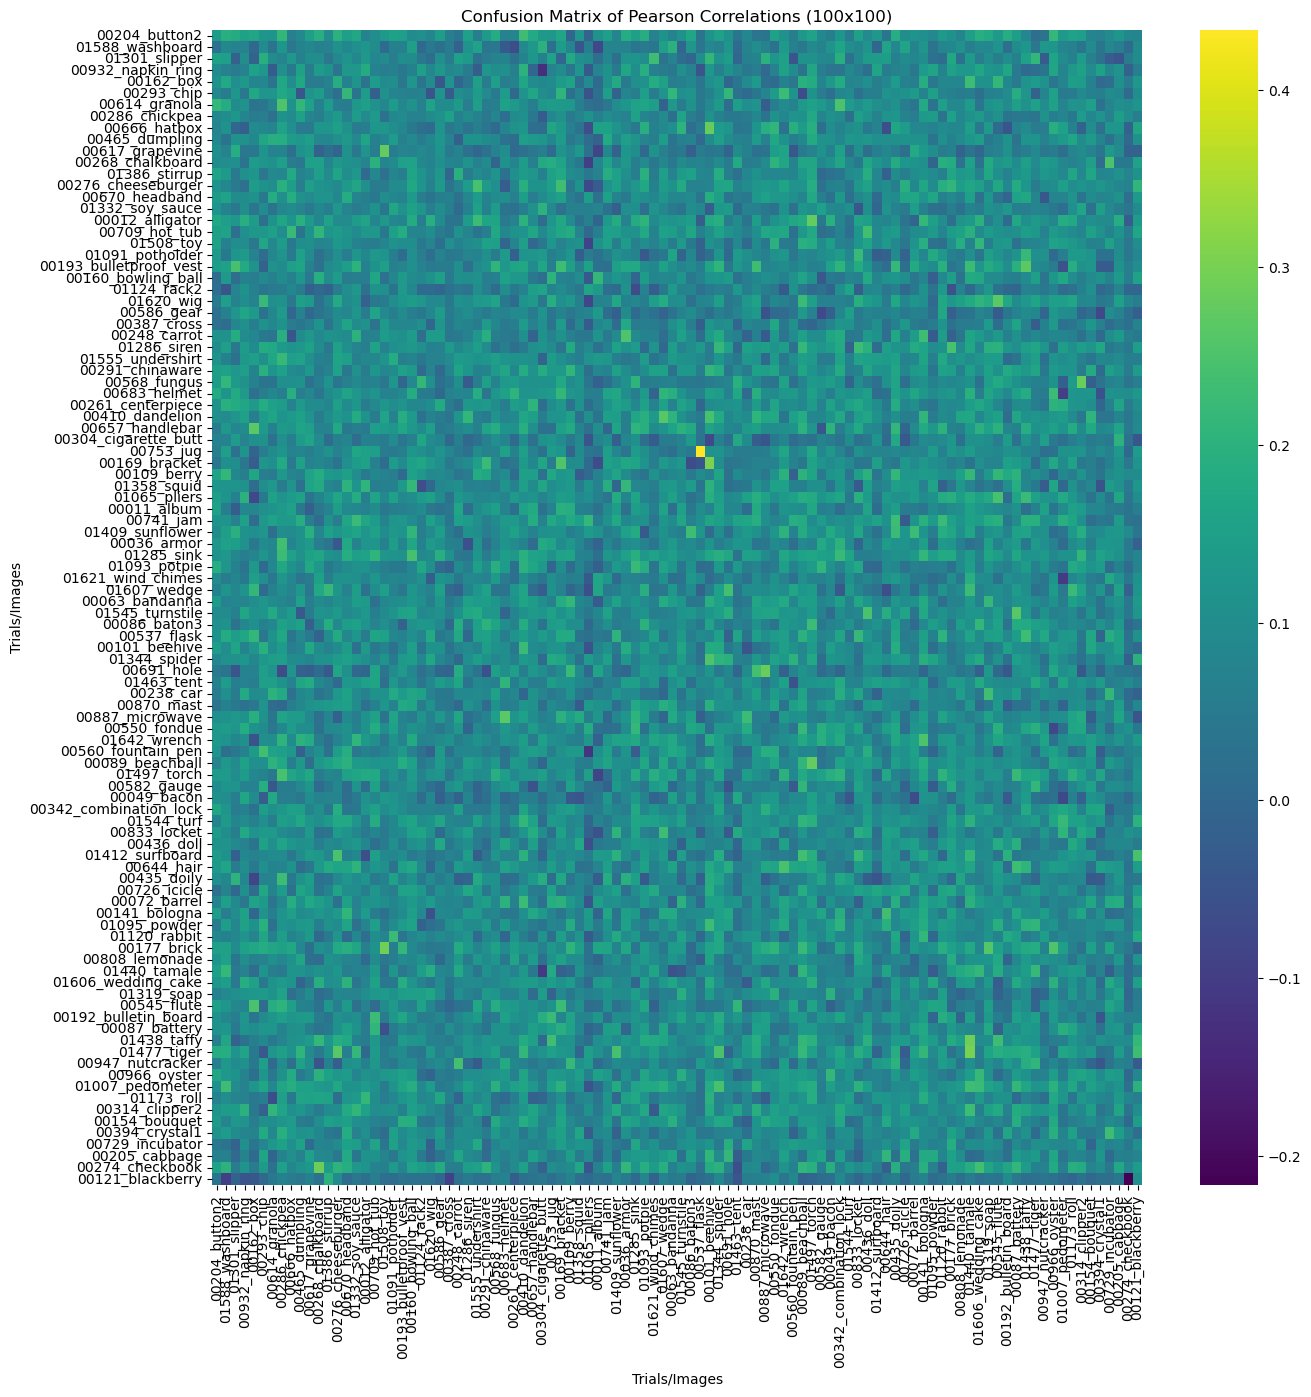

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Function to load images and get directory names
def get_image_directories(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Function to compute correlation matrix
def compute_correlation_matrix(session1_data, session2_data, n_images=100):
    correlations = np.zeros((n_images, n_images))
    for i in range(n_images):
        for j in range(n_images):
            correlations[i, j] = pearsonr(session1_data[i].flatten(), session2_data[j].flatten())[0]
    return correlations

# Load EEG data and preprocess it
EEG_PATH = "/Users/samaylakhani/Documents/BCI_Full_Folder/ALllJoined/takehome/sub-01/preprocessed_eeg_training.npy"
data = np.load(EEG_PATH, allow_pickle=True)
preprocessed_eeg_data = data.item()['preprocessed_eeg_data']

# Assuming the EEG data has two sessions per image
session1_data = preprocessed_eeg_data[::2]
session2_data = preprocessed_eeg_data[1::2]

# Get directory names for labels
img_directory_training = "/Users/samaylakhani/Documents/BCI_Full_Folder/ALllJoined/takehome/training_images"
image_directories = get_image_directories(img_directory_training)

# Compute the correlation matrix for the first 100 images
n_images = 100
correlation_matrix = compute_correlation_matrix(session1_data[:n_images], session2_data[:n_images])

# Plotting the correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, xticklabels=image_directories[:n_images], yticklabels=image_directories[:n_images], cmap='viridis')
plt.title('Confusion Matrix of Pearson Correlations (100x100)')
plt.xlabel('Trials/Images')
plt.ylabel('Trials/Images')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.colorbar(label='Pearson Correlation')
plt.show()


In [21]:
def plot_boxplots(same_image_corrs, different_image_corrs):
    plt.figure(figsize=(10, 5))
    plt.boxplot([same_image_corrs, different_image_corrs], labels=['Same image', 'Different image'])
    plt.title('Boxplot of EEG Correlations')
    plt.ylabel('Correlation Coefficient')
    plt.show()

plot_boxplots(same_image_corrs, different_image_corrs)


NameError: name 'same_image_corrs' is not defined

In [47]:
print("EEG data shape:", eeg_data.shape)


EEG data shape: (1654, 10, 4, 17, 100)
